In [1]:
import torch
import torchvision
train = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True)

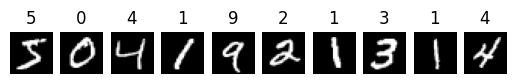

In [2]:
import matplotlib.pyplot as plt

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(train[i][0],cmap='gray')
  plt.title(train[i][1])
  plt.axis('off')

In [3]:
import numpy as np

x_train = [np.array(train[i][0]) for i in range(len(train))][:5000]
y_train = [np.array(train[i][1]) for i in range(len(train))][:5000]
x_test = [np.array(test[i][0]) for i in range(len(test))][:1000]
y_test = [np.array(test[i][1]) for i in range(len(test))][:1000]

len(x_train),len(y_train),len(x_test),len(y_test)

(5000, 5000, 1000, 1000)

In [4]:
x_train = np.stack(x_train)
x_train = x_train.reshape((5000,28*28))
x_train.shape

(5000, 784)

In [5]:
x_test = np.stack(x_test)
x_test = x_test.reshape((1000,28*28))
x_test.shape

(1000, 784)

In [6]:
x_train=x_train/255
x_test=x_test/255

In [7]:
def generate_pairs(X,y):

  X_pairs = []
  y_pairs = []

  for i in range(len(X)):
    digit = y[i]
    positive_digit_index = np.random.choice(np.where(y==digit)[0])
    X_pairs.append([X[i],X[positive_digit_index]])
    y_pairs.append([0])
    negative_digit_index = np.random.choice(np.where(y!=digit)[0])
    X_pairs.append([X[i],X[negative_digit_index]])
    y_pairs.append([1])

  indices = np.arange(len(X_pairs))
  np.random.shuffle(indices)
  return np.array(X_pairs)[indices], np.array(y_pairs)[indices]


In [8]:
X_train_pairs,y_train_pairs = generate_pairs(x_train,y_train)
X_test_pairs,y_test_pairs = generate_pairs(x_test,y_test)

In [9]:
X_train_pairs.shape,y_train_pairs.shape,X_test_pairs.shape,y_test_pairs.shape

((10000, 2, 784), (10000, 1), (2000, 2, 784), (2000, 1))

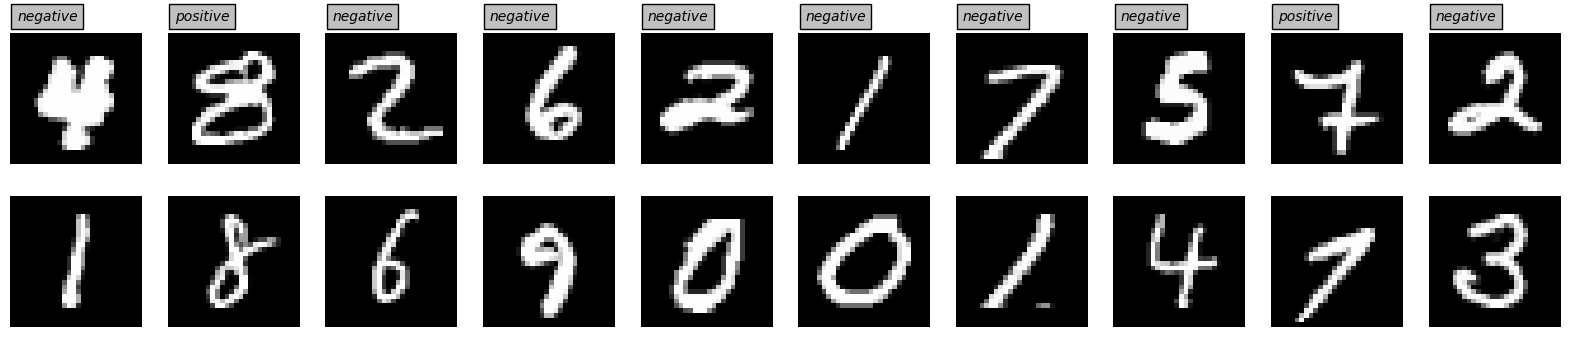

In [10]:
def display_pairs(X,y,correct=None):
  n=10
  plt.figure(figsize=(20,6))
  for i,(image1,image2) in enumerate(zip(X[:n,0],X[:n,1])):
    label=int(y[:n][i][0])
    text = 'positive' if label ==0 else 'negative'
    color = 'silver'
    if correct is not None:
      text = 'Same' if label ==0 else "Different"
      color = 'green' if correct[:n][i][0] else 'red'
    ax = plt.subplot(3,n,i+1)
    ax.text(1,-3,text,style='italic',bbox={"facecolor": color, "pad": 4})
    plt.imshow(image1.reshape(28, 28), cmap="gray")
    plt.axis("off")
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(image2.reshape(28, 28), cmap="gray")
    plt.axis("off")
  plt.show()

display_pairs(X_train_pairs,y_train_pairs)

In [11]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class TwinNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128)
    )
  def forward(self,x):
    return self.network(x)

In [12]:
def euclidean_distance(twin1_output,twin2_output):
  return torch.norm(twin1_output - twin2_output,p=2,dim=1,keepdim=True)

In [13]:
class ContrastiveLoss(nn.Module):

  def __init__(self,margin=1.0):
    super().__init__()
    self.margin = margin

  def forward(self,y,d):
    y = y.float()
    loss = (1-y)/2*torch.square(d)+y/2*torch.square(torch.maximum(torch.tensor(0.0),self.margin-d))
    return torch.mean(loss)

In [14]:
train_dataset = TensorDataset(torch.tensor(X_train_pairs[:, 0], dtype=torch.float32), torch.tensor(X_train_pairs[:, 1], dtype=torch.float32), torch.tensor(y_train_pairs, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_pairs[:, 0], dtype=torch.float32), torch.tensor(X_test_pairs[:, 1], dtype=torch.float32), torch.tensor(y_test_pairs, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [21]:
model = TwinNetwork()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for data1,data2,labels in train_loader:
    optimizer.zero_grad()
    output1 = model(data1)
    output2 = model(data2)
    distance = euclidean_distance(output1,output2)
    loss = criterion(labels,distance)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.053618705768983206
Epoch 2/10, Loss: 0.025876659572648165
Epoch 3/10, Loss: 0.014740572480586009
Epoch 4/10, Loss: 0.009357046177491736
Epoch 5/10, Loss: 0.005940697109401107
Epoch 6/10, Loss: 0.0044875042118762915
Epoch 7/10, Loss: 0.00290560542911547
Epoch 8/10, Loss: 0.0022016530779313845
Epoch 9/10, Loss: 0.001757487023235135
Epoch 10/10, Loss: 0.0015248850884530456


In [25]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data1, data2, labels in test_loader:
        output1 = model(data1)
        output2 = model(data2)
        distance = euclidean_distance(output1, output2)
        predictions = (distance > 0.5).float().squeeze()

        correct += (predictions.squeeze() == labels.squeeze()).sum().item()
        total += labels.size(0)
    print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 93.9%


In [26]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data1, data2, labels in train_loader:
        output1 = model(data1)
        output2 = model(data2)
        distance = euclidean_distance(output1, output2)
        predictions = (distance > 0.5).float().squeeze()

        correct += (predictions.squeeze() == labels.squeeze()).sum().item()
        total += labels.size(0)
    print(f'Train Accuracy: {100 * correct / total}%')

Train Accuracy: 99.96%
